The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X_hat[0].shape=torch.Size([2, 3, 321, 481]),X_hat[1].shape=torch.Size([2, 3, 321, 481])
U_hat[0].shape=torch.Size([6, 3, 321, 481]),U_hat[1].shape=torch.Size([6, 3, 321, 481])
torch.Size([8, 3, 321, 481]),torch.Size([8, 3, 321, 481])
torch.Size([2, 3, 321, 481]),torch.Size([2, 3, 321, 481])
torch.Size([6, 3, 321, 481]),torch.Size([6, 3, 321, 481])


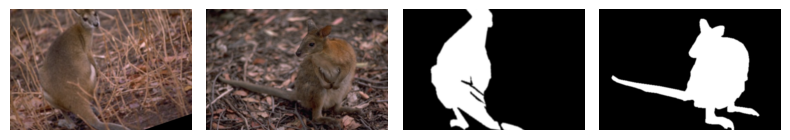

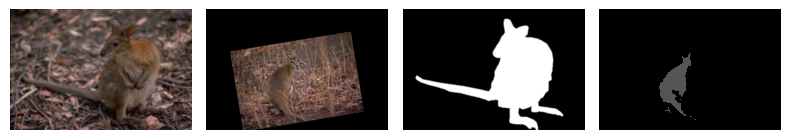

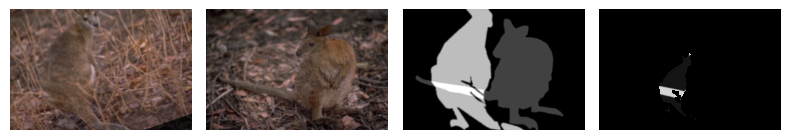

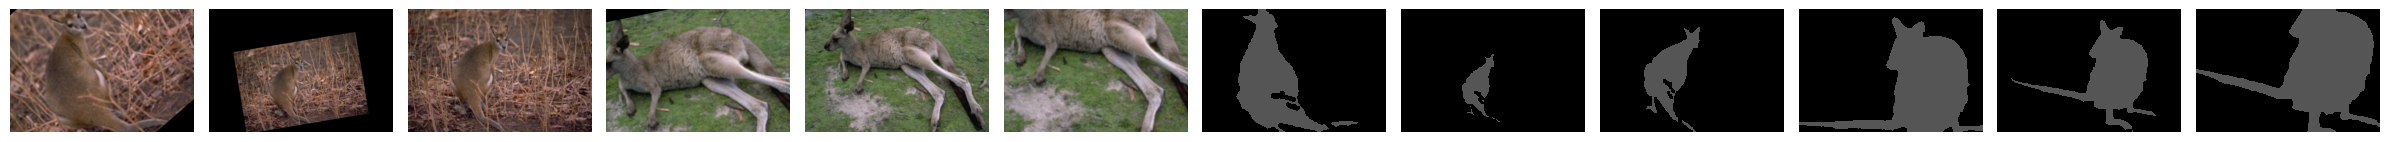

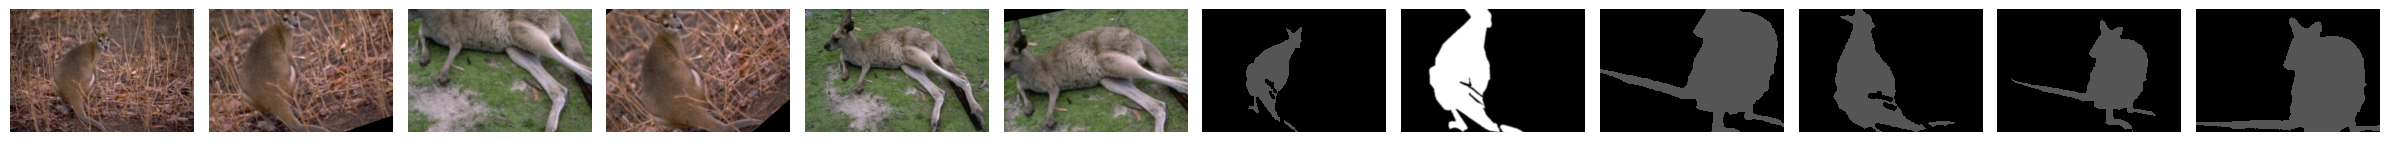

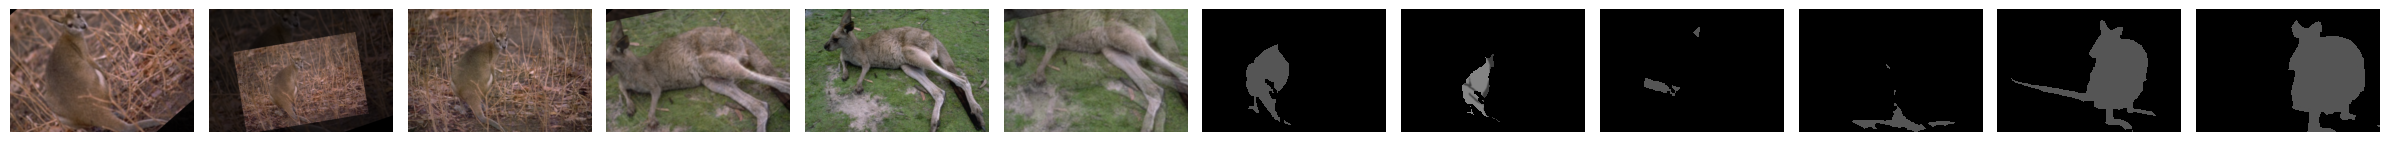

In [102]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import sys
import torch
import torch.utils.data as data
import torch.nn as nn
import easydict
import kornia as K


sys.path.append("..")
import mixmatch
import datasets
import transformations as custom_transforms


# Create SegmentationDatasetLabeled
labeled_dataset = datasets.SegmentationDatasetLabeled(
    dir_images="./my_dataset/images/",
    dir_masks="./my_dataset/masks/",
    #transform=transforms.ToTensor()
)

# Create DataLoader for SegmentationDatasetLabeled
batch_size = 2  # set your desired batch size
labeled_dataloader = data.DataLoader(
    labeled_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1  # set the number of worker processes for loading data
)

# Create SegmentationDatasetUnlabeled
unlabeled_dataset = datasets.SegmentationDatasetUnlabeled(
    dir_images="./my_dataset/images/",
    #transform=transforms.ToTensor()
)

# Create DataLoader for SegmentationDatasetUnlabeled
unlabeled_dataloader = data.DataLoader(
    unlabeled_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1  # set the number of worker processes for loading data
)

import torch

args = easydict.EasyDict()
args.train_iteration = 1

# Transforamtion
k1 = custom_transforms.GaussianNoiseChannelwise((0.01, 0.02, 0.025))
k2 = K.augmentation.RandomGaussianBlur((3,3),sigma=(5.,5.),p=1)
k3 = K.augmentation.RandomHorizontalFlip(p=1)
k4 = K.augmentation.RandomAffine([-45., 45.], [0., 0.15], [0.5, 1.5], [0., 0.15])

img_trans = nn.ModuleList([k1,k2,k3,k4])
mask_trans = nn.ModuleList([k2,k3,k4]) 
invert_trans  = nn.ModuleList([k3,k4])

transform = custom_transforms.MyAugmentation(img_trans,mask_trans,invert_trans)



labeled_train_iter = iter(labeled_dataloader)
unlabeled_train_iter = iter(unlabeled_dataloader)

# Iterate over index iterator until the desired number of iteration is achived
for batch_idx in range(args.train_iteration):
    
    # Iterate over the end if necessarybatch_stacked
    try:
        data_l, labels = next(labeled_train_iter)
    except:
        labeled_train_iter = iter(labeled_dataloader)
        data_l, labels = next(labeled_train_iter)

    try:
        data_u = next(unlabeled_train_iter)
    except:
        unlabeled_train_iter = iter(unlabeled_dataloader)
        data_u = next(unlabeled_train_iter)

    aug_data_l,aug_data_u = mixmatch.mixmatch(labeled_batch=data_l,
                                              labels=labels,
                                              unlabeled_batch=data_u,
                                              clf=None,
                                              augumentation=transform,
                                              K=3,
                                              T=0.75,
                                              alpha=1)